# Balanced buckets

Simulation of the benefit in the number of hop of having balanced DHT buckets.

In [104]:
from binary_trie import Trie, bytes_to_bitstring, int_to_bitstring, bitstring_to_int, bitstring_to_bytes
import multihash as mh
import hashlib as hl
import math, os, random
import numpy as np

## Implementation

System parameters:

In [105]:
# maximal number of buckets in a peer's routing table,
# equivalent to bit size of the keyspace
n_buckets = 256

# length of a kademlia key in bytes
keylen = 32

# bucket containing the closest peer
closest_bucket = 20

# number of peers participating in the network
peers_number = 25000

# ipfs dht concurrency factor, defining how many
# peers are contacted concurrently at each hop
concurrency = 10

# replication factor for all data in the ipfs dht
repl = 20

# size of a bucket in a peer's routing table
bucket_size = 20

In [106]:
# returns a random key in the kademlia keyspace
def random_key():
    return os.urandom(keylen)

In [107]:
def byte_to_int(b: bytes) -> int:
    return int.from_bytes(b, byteorder='big')

In [108]:
def bxor(b1, b2):
    n_b1 = np.frombuffer(b1, dtype='uint8')
    n_b2 = np.frombuffer(b2, dtype='uint8')

    return (n_b1 ^ n_b2).tobytes()

In [109]:
def log_dist(bs0, bs1: bytes) -> int:
    xored = bxor(bs0, bs1)
    dist = byte_to_int(xored)
    if dist == 0:
        return n_buckets
    return n_buckets-math.floor(math.log2(dist))-1


In [110]:
def n_closest(t: Trie, k: bytes, n: int):
    if t.size == 0:
        # TODO: remove me
        print("error nil trie")
        return
    closest = t.n_closest_keys(bytes_to_bitstring(k, l=n_buckets), n)
    return [bitstring_to_bytes(bs) for bs in closest]


In [111]:
# balance_bucket() is given as input a binary trie t, and an integer n,
# it returns a balanced list of n random keys. The list is considered as
# balanced because, if possible it will contain the same number of keys,
# starting with the prefix "0" and "1", the same number of prefixes "00",
# "01", "10", "11" etc.
# this function is recursive
def balance_bucket(t: Trie, n: int):
    if n == 0 or t is None:
        # invalid parameters
        return []

    # number of keys wanted with prefix "0" and "1"
    half = math.ceil(n/2)

    # if at least one branc is undefined, we reached a leaf
    if t.branch[0] is None or t.branch[1] is None:
        # return a list containing the leaf's key
        return [t.key]
    # if both branches have enough candidates
    elif t.branch[0].size >= half and t.branch[1].size >= half:
        add0, add1 = 0, 0
        # odd number of peers to return, need to select a branch
        # to have 1 additional peer
        if n % 2 == 1:
            if random.randint(0, 1) == 0:
                add0 += 1
            else:
                add1 += 1
        # return the union of the n/2 balanced peers starting with
        # prefix "0" and the n/2 starting with prefix "1"
        return balance_bucket(t.branch[0], half-add0) + balance_bucket(t.branch[1], half-add1)
    # less than half keys with prefix "1"
    elif t.branch[0].size >= half:
        b1 = t.branch[1].size
        # return all keys with prefix "1", and a balanced list from
        # bucket 0
        return balance_bucket(t.branch[0], n-b1) + balance_bucket(t.branch[1], b1)
    # less than half keys with prefix "0"
    elif t.branch[1].size >= half:
        b0 = t.branch[0].size
        # return all keys with prefix "0", and a balanced list from
        # with prefix "1"
        return balance_bucket(t.branch[0], b0) + balance_bucket(t.branch[1], n-b0)
    else:
        # there are less than n keys in t, return all keys
        return t.match_prefix_keys(prefix="")

In [118]:
def generate_sim(n_peers, bucket_size):
    # binary trie storing all peers ids
    sim_trie = Trie()
    # list of peers for this simulation
    sim_peers = []

    # routing table of the simluation with random buckets
    sim_peers_random = {}
    # routing table of the simulation with balanced buckets
    sim_peers_balanced = {}

    # generate random peerids and populate the binary trie
    for _ in range(n_peers):
        # generate random peerid
        peerid = random_key()
        # add peerid to peer trie
        while not sim_trie.add(bytes_to_bitstring(peerid)):
            # add returns false if key already in trie
            # generate new identity
            peerid = random_key()

        # add peerid to list of peerids
        sim_peers.append(peerid)

        # create entry for peerid in both simulations routing tables
        sim_peers_random[peerid] = {}
        sim_peers_balanced[peerid] = {}

    # iterate on all possible buckets, large to small buckets, 0 prefix to 1 prefix
    for bid in range(closest_bucket):
        for i in range(2**(bid+1)):
            # prefix of the current bucket
            bucket_prefix = int_to_bitstring(i, bid+1)
            # all peers falling in this bucket
            candidates = sim_trie.match_prefix_keys(bucket_prefix)

            # if no candidates, continue
            if len(candidates) == 0:
                continue

            # flip last bit
            target_prefix = bucket_prefix[:-1]+str(1-int(bucket_prefix[-1]))

            # targets are peers that could use the candidates (of the current bucket)
            # in their routing table
            targets = sim_trie.match_prefix_keys(target_prefix)


            # bucket root is the subtrie representing the bucket
            bucket_root = sim_trie.find_trie(bucket_prefix)
            if bucket_root is None:
                # bucket root could be undefined if subkey not in the trie
                # we need to find the closest child
                i = 0
                while bucket_root is None:
                    i += 1
                    # find the first existing parent
                    bucket_root = sim_trie.find_trie(bucket_prefix[:-i])
                # select the appropriate child as the bucket root
                bucket_root = bucket_root.branch[int(bucket_prefix[-i+1])]

            # iterate on all targets, and define which candidates are selected
            # for their bucket
            for t in targets:
                # if more than `bucket_size` candidates, select `bucket_size` of them
                # at random, else take them all
                random_bucket = [bitstring_to_bytes(p) for p in 
                    random.sample(candidates, min(bucket_size, len(candidates)))]
                # add these peers to t's routing table, in bucket bid
                sim_peers_random[bitstring_to_bytes(t)][bid] = random_bucket

                # randomly select candidates in a balanced manner
                balanced_bucket = [bitstring_to_bytes(p) for p in balance_bucket(bucket_root, min(bucket_size, len(candidates)))]
                # add these peers to t's routing table, in bucket bid
                sim_peers_balanced[bitstring_to_bytes(t)][bid] = balanced_bucket

    return sim_trie, sim_peers, sim_peers_random, sim_peers_balanced


58.4 s for bucket_size = 20


In [114]:
def lookup_n_hops(peer, key, peers, trie, concurrency, repl):
    # closest peers are the peers storing data associated with key
    closest_peers = n_closest(trie, key, repl)

    # hop count
    hop = 0
    if peer in closest_peers:
        # if peer store is among the closest peers, 0 hop
        return hop

    # binary trie helping find the closest peers to key in 
    # the node's routing table
    req_trie = Trie()
    # bucket id, corresponding to key
    bid = log_dist(peer, key)

    if bid in peers[peer] and len(peers[peer][bid]) > 0:
        # if this bucket is populated, add peers to req_trie
        for peer_neighbor in peers[peer][bid]:
            req_trie.add(bytes_to_bitstring(peer_neighbor, l=n_buckets))
    else:
        buckets = list(peers[peer].keys())
        found_higher = False
        for b in range(bid+1, max(buckets)+1):
            if b in buckets and len(peers[peer][b]) > 0:
                for peer_neighbor in peers[peer][b]:
                    req_trie.add(bytes_to_bitstring(peer_neighbor, l=n_buckets))
                    found_higher = True
        if not found_higher:
            for b in range(bid-1, -1, -1):
                if b in buckets and len(peers[peer][b]) > 0:
                    for peer_neighbor in peers[peer][b]:
                        req_trie.add(bytes_to_bitstring(peer_neighbor, l=n_buckets))
                    break # we are only interested in the closest bucket
                
    req_peers = n_closest(req_trie, key, concurrency)

    while True:
        hop += 1
        for c in closest_peers:
            if c in req_peers:
                return hop

        req_trie = Trie()
        for p in req_peers:
            bid = log_dist(p, key)

            if bid in peers[p] and len(peers[p][bid]) > 0:
                for peer_neighbor in peers[p][bid]:
                    req_trie.add(bytes_to_bitstring(peer_neighbor, l=n_buckets))
            else:
                buckets = list(peers[p].keys())
                found_higher = False
                for b in range(bid+1, max(buckets)+1):
                    if b in buckets and len(peers[p][b]) > 0:
                        for peer_neighbor in peers[p][b]:
                            req_trie.add(bytes_to_bitstring(peer_neighbor, l=n_buckets))
                            found_higher = True
                if not found_higher:
                    for b in range(bid-1, -1, -1):
                        if b in buckets and len(peers[p][b]) > 0:
                            for peer_neighbor in peers[p][b]:
                                req_trie.add(bytes_to_bitstring(peer_neighbor, l=n_buckets))
                            break # we are only interested in the closest bucket
                    
        req_peers = n_closest(req_trie, key, 20)

# Running experiments

In [124]:
def run_sim(peers_number, bucket_size, concurrency, repl, n_requests, iterations=1):
    results = []
    for _ in range(iterations):
        sim_trie, sim_peers, sim_peers_random, sim_peers_balanced = generate_sim(peers_number, bucket_size)

        sim_random_hop_count = []
        for i in range(n_requests):
            peer = random.choice(sim_peers)
            key = random_key()
            n_hop = lookup_n_hops(peer, key, sim_peers_random, sim_trie, concurrency, repl)
            sim_random_hop_count.append(n_hop)
            
        sim_balanced_hop_count = []
        for i in range(n_requests):
            peer = random.choice(sim_peers)
            key = random_key()
            n_hop = lookup_n_hops(peer, key, sim_peers_balanced, sim_trie, concurrency, repl)
            sim_balanced_hop_count.append(n_hop)

        sim_avg_random = sum(sim_random_hop_count)/len(sim_random_hop_count)
        sim_avg_balanced = sum(sim_balanced_hop_count)/len(sim_balanced_hop_count)

        results.append((sim_avg_random, sim_avg_balanced))
    
    return results


In [132]:
results = run_sim(peers_number=25000, bucket_size=20, concurrency=10, repl=20, n_requests=10000, iterations=5)

In [133]:
results

[(1.9292, 1.8984),
 (1.9224, 1.8897),
 (1.9297, 1.8887),
 (1.9287, 1.8856),
 (1.9263, 1.894)]

In [134]:
sum_random = 0
sum_balanced = 0
for r0, r1 in results:
    sum_random += r0
    sum_balanced += r1
avg_random = sum_random / len(results)
avg_balanced = sum_balanced / len(results)

In [138]:
print("Average random buckets:", avg_random)
print("Average balanced buckets:", avg_balanced)
print("Improvement: "+str(round(100*(1-avg_balanced/avg_random), 2))+"%")

Average random buckets: 1.92726
Average balanced buckets: 1.89128
Improvement: 1.87%


In [141]:
# multiple bucket size simulation
# not realistic because all queries are exactly concurrent

results = {}
for i in range(10, 110, 10):
    results[i] = run_sim(peers_number=25000, bucket_size=i, concurrency=10, repl=20, n_requests=10000, iterations=5)

In [148]:
results

{10: [(2.173, 2.0841),
  (2.1698, 2.0799),
  (2.1568, 2.0891),
  (2.1686, 2.0895),
  (2.159, 2.0849)],
 20: [(1.9298, 1.8848),
  (1.9234, 1.8918),
  (1.9229, 1.8925),
  (1.9262, 1.8952),
  (1.9292, 1.891)],
 30: [(1.8677, 1.8426),
  (1.8679, 1.8404),
  (1.8677, 1.8459),
  (1.8658, 1.8457),
  (1.8738, 1.8385)],
 40: [(1.8329, 1.8125),
  (1.838, 1.8051),
  (1.8326, 1.8054),
  (1.8323, 1.8099),
  (1.8338, 1.8123)],
 50: [(1.8062, 1.7731),
  (1.8019, 1.7749),
  (1.8087, 1.7795),
  (1.8054, 1.7773),
  (1.8083, 1.7721)],
 60: [(1.7664, 1.742),
  (1.7862, 1.7458),
  (1.7789, 1.7396),
  (1.7823, 1.7488),
  (1.7751, 1.7394)],
 70: [(1.7575, 1.7157),
  (1.7575, 1.7133),
  (1.7561, 1.7039),
  (1.7551, 1.7182),
  (1.7546, 1.7122)],
 80: [(1.7316, 1.6825),
  (1.7265, 1.6859),
  (1.7343, 1.6871),
  (1.7285, 1.6769),
  (1.7239, 1.6872)],
 90: [(1.7144, 1.6609),
  (1.7039, 1.6495),
  (1.7105, 1.6741),
  (1.7069, 1.6662),
  (1.7074, 1.6678)],
 100: [(1.7009, 1.6315),
  (1.6875, 1.6344),
  (1.6958, 1.63

In [146]:
avg_results = {}
for r in results:
    sum0 = 0
    sum1 = 0
    for h0, h1 in results[r]:
        sum0 += h0
        sum1 += h1
    avg0 = sum0/len(results[r])
    avg1 = sum1/len(results[r])
    avg_results[r] = (avg0, avg1, str(round(100*(1-avg1/avg0), 2))+"%")

In [147]:
avg_results

{10: (2.1654400000000003, 2.0855000000000006, '3.69%'),
 20: (1.9263000000000001, 1.8910600000000002, '1.83%'),
 30: (1.8685800000000001, 1.8426200000000001, '1.39%'),
 40: (1.8339199999999998, 1.80904, '1.36%'),
 50: (1.8061, 1.7753800000000002, '1.7%'),
 60: (1.77778, 1.74312, '1.95%'),
 70: (1.7561600000000002, 1.71266, '2.48%'),
 80: (1.72896, 1.68392, '2.61%'),
 90: (1.7086200000000002, 1.6637, '2.63%'),
 100: (1.69258, 1.6326600000000002, '3.54%')}

In [156]:
import matplotlib.pyplot as plt
plt.rc('font', size=28)

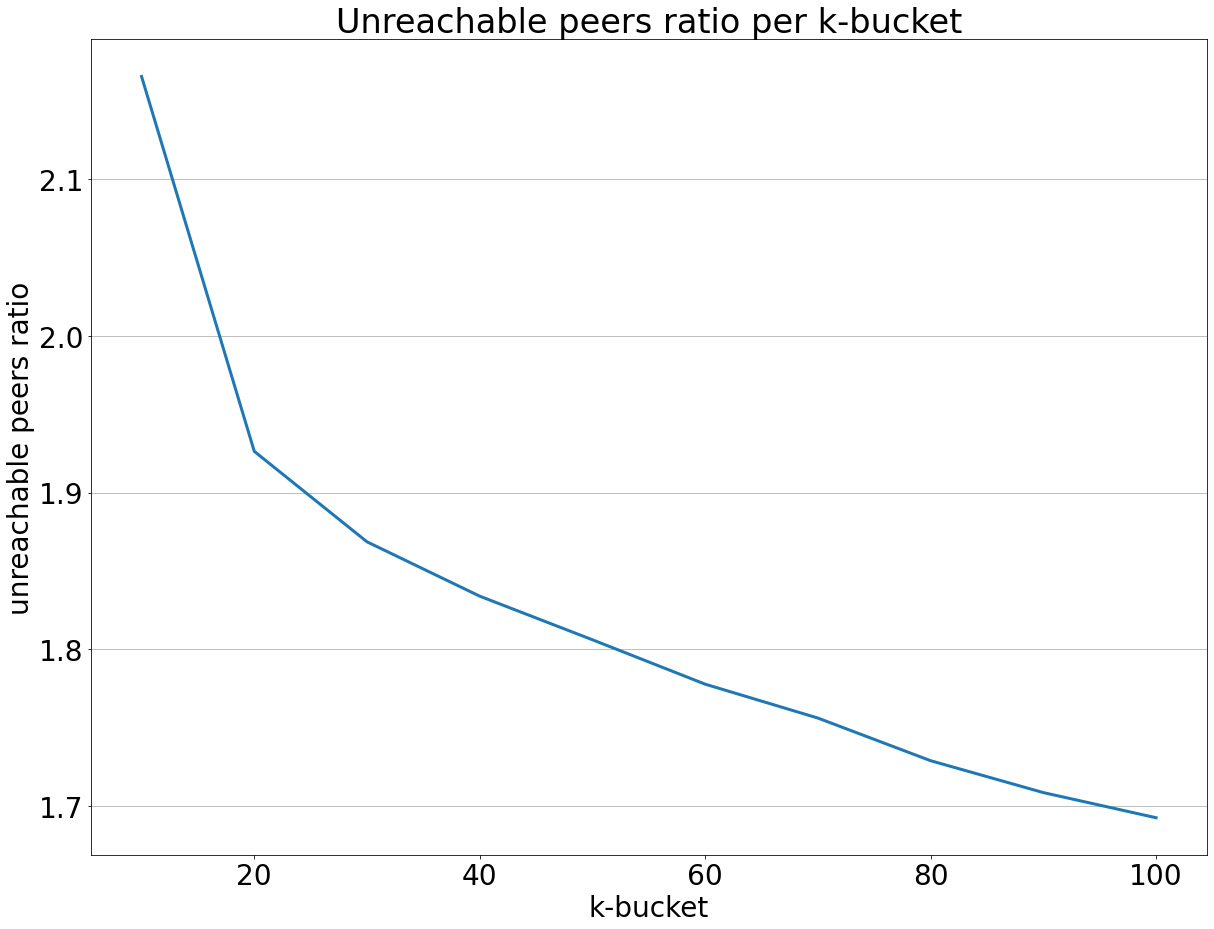

In [160]:
fig = plt.figure(figsize=(20,15), facecolor='white', edgecolor ='black')

plt.grid(axis='y')

plt.plot(avg_results.keys(), [avg_results[r][0] for r in avg_results], lw=3)

plt.xlabel("k-bucket")
plt.ylabel("average number of hops")
plt.title("Unreachable peers ratio per k-bucket")

plt.show()

# Results

## Simulation 0

Parameters: 
```python
peers_number=25000, bucket_size=20, concurrency=10, repl=20, n_requests=10000, iterations=5
```

results: 
```python
[(1.9292, 1.8984),
 (1.9224, 1.8897),
 (1.9297, 1.8887),
 (1.9287, 1.8856),
 (1.9263, 1.894)]

Average random buckets: 1.92726
Average balanced buckets: 1.89128
Improvement: 1.87%

Time: 10 min
```

## Simulation 1

Parameters:
```python
results = {}
for i in range(10, 110, 10):
    results[i] = run_sim(peers_number=25000, bucket_size=i, concurrency=10, repl=20, n_requests=10000, iterations=5)
```
results: 
```python
{10: [(2.173, 2.0841),
  (2.1698, 2.0799),
  (2.1568, 2.0891),
  (2.1686, 2.0895),
  (2.159, 2.0849)],
 20: [(1.9298, 1.8848),
  (1.9234, 1.8918),
  (1.9229, 1.8925),
  (1.9262, 1.8952),
  (1.9292, 1.891)],
 30: [(1.8677, 1.8426),
  (1.8679, 1.8404),
  (1.8677, 1.8459),
  (1.8658, 1.8457),
  (1.8738, 1.8385)],
 40: [(1.8329, 1.8125),
  (1.838, 1.8051),
  (1.8326, 1.8054),
  (1.8323, 1.8099),
  (1.8338, 1.8123)],
 50: [(1.8062, 1.7731),
  (1.8019, 1.7749),
  (1.8087, 1.7795),
  (1.8054, 1.7773),
  (1.8083, 1.7721)],
 60: [(1.7664, 1.742),
  (1.7862, 1.7458),
  (1.7789, 1.7396),
  (1.7823, 1.7488),
  (1.7751, 1.7394)],
 70: [(1.7575, 1.7157),
  (1.7575, 1.7133),
  (1.7561, 1.7039),
  (1.7551, 1.7182),
  (1.7546, 1.7122)],
 80: [(1.7316, 1.6825),
  (1.7265, 1.6859),
  (1.7343, 1.6871),
  (1.7285, 1.6769),
  (1.7239, 1.6872)],
 90: [(1.7144, 1.6609),
  (1.7039, 1.6495),
  (1.7105, 1.6741),
  (1.7069, 1.6662),
  (1.7074, 1.6678)],
 100: [(1.7009, 1.6315),
  (1.6875, 1.6344),
  (1.6958, 1.6317),
  (1.6899, 1.6345),
  (1.6888, 1.6312)]}

{10: (2.1654400000000003, 2.0855000000000006, '3.69%'),
 20: (1.9263000000000001, 1.8910600000000002, '1.83%'),
 30: (1.8685800000000001, 1.8426200000000001, '1.39%'),
 40: (1.8339199999999998, 1.80904, '1.36%'),
 50: (1.8061, 1.7753800000000002, '1.7%'),
 60: (1.77778, 1.74312, '1.95%'),
 70: (1.7561600000000002, 1.71266, '2.48%'),
 80: (1.72896, 1.68392, '2.61%'),
 90: (1.7086200000000002, 1.6637, '2.63%'),
 100: (1.69258, 1.6326600000000002, '3.54%')}

 Time: 217 min
 ```

In [99]:
sim_random_hop_count = []
for i in range(10000):
    peer = random.choice(sim_peers)
    key = random_key()
    n_hop = lookup_n_hops(peer, key, sim_peers_random, sim_trie, concurrency, repl)
    sim_random_hop_count.append(n_hop)


In [100]:
sim_avg_random = sum(sim_random_hop_count)/len(sim_random_hop_count)
sim_avg_random

1.9227

In [101]:
sim_balanced_hop_count = []
for i in range(10000):
    peer = random.choice(sim_peers)
    key = random_key()
    n_hop = lookup_n_hops(peer, key, sim_peers_balanced, sim_trie, concurrency, repl)
    sim_balanced_hop_count.append(n_hop)

In [102]:
sim_avg_balanced = sum(sim_balanced_hop_count)/len(sim_balanced_hop_count)
sim_avg_balanced

1.8973

In [131]:
print("Average random buckets", sim_avg_random)
print("Average balanced buckets", sim_avg_balanced)
print(1-sim_avg_balanced/sim_avg_random)

Average random buckets 1.9227
Average balanced buckets 1.8973
0.013210589275498008
